In [1]:
%load_ext autoreload

%autoreload

In [2]:
print(1)


1


In [3]:
from ipywidgets import interact, IntSlider

In [5]:
import matplotlib.pyplot as plt

In [4]:
import numpy

In [15]:
import problem
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import yaml

from problem import *

In [16]:
with open('config_basic.yml', 'r') as file:
        c = yaml.safe_load(file)

In [17]:
# Create spatial discretisation 
lat_first = c['spatial_discretisation']['lat_first']
lat_final = c['spatial_discretisation']['lat_final']
lat_n     = c['spatial_discretisation']['lat_n']
lng_first = c['spatial_discretisation']['lng_first']
lng_final = c['spatial_discretisation']['lng_final']
lng_n     = c['spatial_discretisation']['lng_n']

lat,lng = jnp.mgrid[lat_first:lat_final:lat_n*1j,
                    lng_first:lng_final:lng_n*1j]

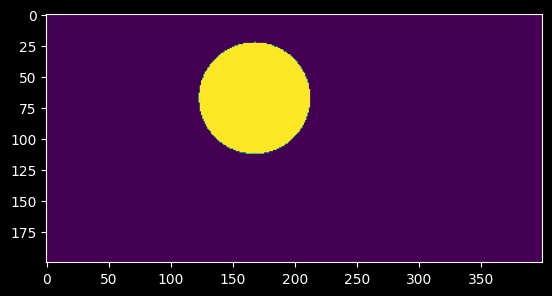

In [18]:
_, _, v = problem.ic_flow_v_only(lat,lng)
plt.imshow(v[0]+v[1])

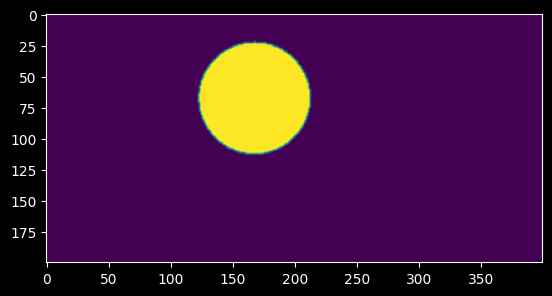

In [19]:
# BLUR V
v += (jnp.roll(v, 1,axis=-1)
     +jnp.roll(v,-1,axis=-1)
     +jnp.roll(v, 1,axis=-2)
     +jnp.roll(v,-1,axis=-2))
v/=5
plt.imshow(v[0])

In [20]:
def gradient(y):
    return jnp.array( (ptheta(y), plambda(y)))

-40.0 40.0


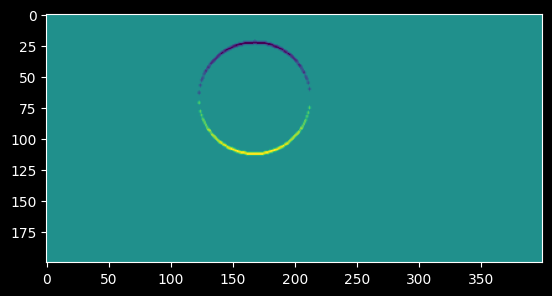

In [21]:
rhs = -divergence(v)
plt.imshow(-rhs)

print(jnp.amin(rhs), jnp.amax(rhs))

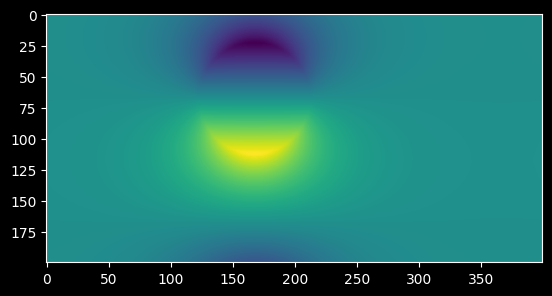

In [22]:
import jax.scipy as jsp
q, _ = jsp.sparse.linalg.cg(laplacian, rhs , maxiter= 10000)
plt.imshow( q)

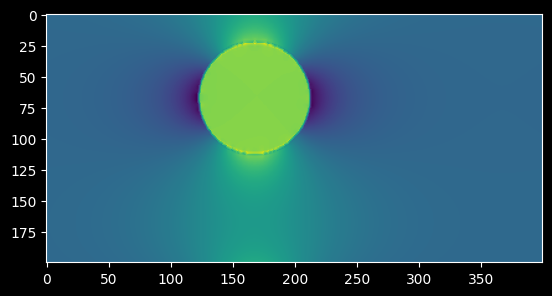

In [23]:
v_f = v +gradient(q)
plt.imshow(v_f[0])
#plt.imshow(v_f[1])

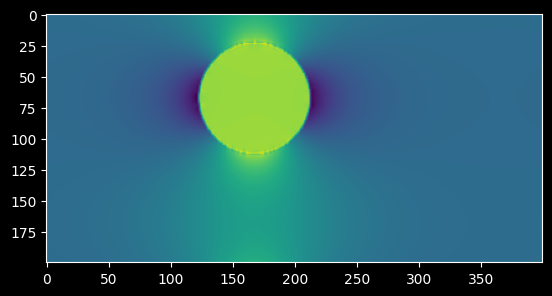

In [24]:

q, _ = jsp.sparse.linalg.cg(laplacian, -divergence( v_f ), maxiter= 100)
v_f = v_f + gradient(q)
plt.imshow(v_f[0])

-3.758125 6.189681


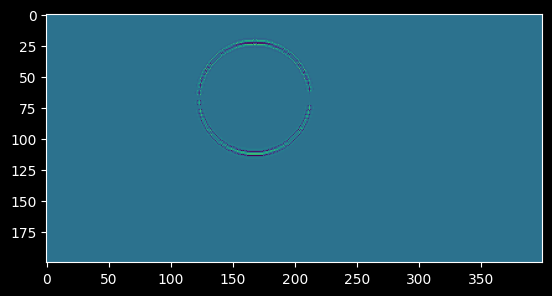

In [25]:
div = divergence(v_f)
plt.imshow(div)
print(jnp.amin(div), jnp.amax(div))

-40.000004 40.000004


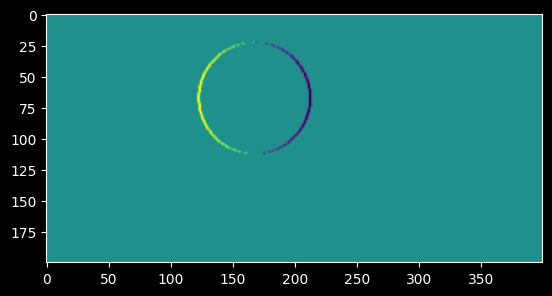

In [28]:
def curl(v):
    return ptheta(v[1]) - plambda(v[0])

c = curl(v_f)
plt.imshow(c)
print(jnp.amin(c), jnp.amax(c))

In [26]:
1

1

In [42]:
print('started')
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Box
print('imported')


# Assuming `data` is your N-dimensional numpy array
data = np.random.rand(100, 200, 30) *jnp.power(jnp.linspace(0,1,200)[None,:,None], jnp.linspace(0,1,30)[None,None,:])  # Example: 3D array
print('data created')

def plot_slice(x=0):
    plt.imshow(data[:, :, x], interpolation='nearest')
    plt.show()

interact(plot_slice, x=IntSlider(min=0, max=data.shape[2]-1, step=1, value=0))

started
imported
data created


interactive(children=(IntSlider(value=0, description='x', max=29), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_slice(x=0)>

interactive(children=(IntSlider(value=0, description='X Dimension', max=29), IntSlider(value=0, description='Y…

<function __main__.plot_2d_slice(x=0, y=0)>

In [58]:
from os.path import isfile
import numpy as np

with open("config_basic.yml", 'r') as file:
    config = yaml.safe_load(file)

def save(config, X):
    
    path = config['save']['save_npy_path']
    
    # If we have set to not overwrite, find lowest number to add to end of file name to avoid overwriting
    if not config['save']['save_npy_overwrite']:
        empty_path_found = False
        i=0
        while not empty_path_found:
            if isfile(path+str(i)+'.npy'):
                i += 1
                
            else:
                empty_path_found = True
                path = path+str(i)
    
    np.save(path, X)
    return True
        
save(config, np.random.rand(10,10))
    

True

In [35]:
 jnp.linspace(0,1,30).shape

(30,)

In [37]:
data[:,:,1]

Array([[0.01534971, 0.00512644, 0.00845492, ..., 0.01684091, 0.0133524 ,
        0.00794466],
       [0.01190635, 0.00984049, 0.01773692, ..., 0.01566396, 0.00438494,
        0.03446   ],
       [0.0078685 , 0.02001289, 0.02536104, ..., 0.01991761, 0.02536866,
        0.01153545],
       ...,
       [0.03191679, 0.01095644, 0.01452739, ..., 0.01637575, 0.02091288,
        0.01205813],
       [0.00992228, 0.00056643, 0.01479072, ..., 0.02427535, 0.02429113,
        0.01509536],
       [0.00183706, 0.01120601, 0.01422979, ..., 0.01486621, 0.02842087,
        0.02069097]], dtype=float32)

In [8]:
import numpy as np

In [9]:
# Assuming `data` is your N-dimensional numpy array
data = np.random.rand(10, 20, 30)  # Example: 3D array
print('data created')

def plot_slice(x=0):
    plt.imshow(data[:, :, x], interpolation='nearest')
    plt.show()

interact(plot_slice, x=IntSlider(min=0, max=data.shape[2]-1, step=1, value=0))

data created


interactive(children=(IntSlider(value=0, description='x', max=29), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_slice(x=0)>

opening path  /mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
/mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
(1800, 3600, 3)


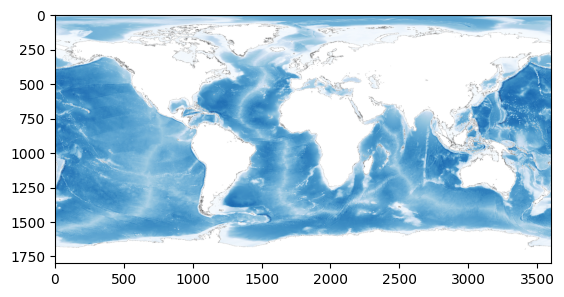

In [2]:
import cv2
import numpy as np
import os

def get_map_path(config):

    if config["map"]["mask_image_path_relative"]:
        print('opening path ', os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        print(os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        return os.path.join( os.getcwd(), config["map"]["mask_image_path"] )
    else:
        return config["map"]["mask_image_path"]


def load_np(config):

    image_np = cv2.imread(get_map_path(config)) 

    return image_np[:,:,::-1]



import matplotlib.pyplot as plt

config = {"map": {"mask_image_path_relative": True, 
                    "mask_image_path": "resources/map/gebco_08_rev_bath_3600x1800_color.jpg"}}

im = load_np(config).astype(int)
print(im.shape)

im[:,:,:] += (np.isclose(im[:,:,0],im[:,:,2], atol=4))[:,:,np.newaxis]*255

im[im>255]=255

plt.imshow(im)
#plt.show()